### This script gets the mean intensity values from the metadata of the SDO HMI data archives, with calibration and detrending for orbital effects

In [6]:
import os
import drms
import pandas as pd
import matplotlib.pyplot as plt
from sunpy.time import parse_time
import datetime
import numpy as np
from scipy.signal import detrend
%matplotlib notebook

In [11]:
def get_meandata_hmi(tstart, tend, days_before=0, days_after=0):
    """
    Fetch the data in the Stanford's servers.  
    Along with DATAMEAN, will get time of the record T_REC, and the Sun - SDO satellite distance for demodulating the intensity variations.  
    The data query must be in a very specific format. Keep this pattern or it will fail. 
    
    Inputs:
        tstart: datetime of the start date of interest. 
        tend: datetime of the end date of interest
        
    Optional Inputs:
        days_before: optionnally, the query can ask for more data before the start date, which can be useful for more accurate detrending
        days_above: save as above, querying for more time after the end time. 
        
    Output:
        Pandas Dataframe that will contain the mean intensity data with a calibrated detrended version of them.
        The units of the mean intensity are in DN/s. The detrended data are therefore also in DN/s but in a different range, 
        conveniently offset within a range of positive values starting at zero.  
    """
    # Define what metadata needs to be queried from the HMI data archive in Stanford. FOR TSI proxy, use 'DATAMEAN'. 
    data_key = 'DATAMEAN'
    # astronimcal unit - needed for calibration
    au = 149597870691.0
    # Instantiate object of the JSOC's Data Record Management System (drms)
    c = drms.Client()
    # Convert time window of interest into a formatted string with optional extra time before and after
    tquery_start = tstart - datetime.timedelta(days=days_before)
    tquery_end = tend + datetime.timedelta(days=days_after)
    # duration of the query time window in days 
    dt = (tquery_end - tquery_start).days
    # Actual query string needed by the drms client. 
    squery = 'hmi.Ic_45s[{:s}_TAI/{:d}d@24h]'.format(tquery_start.strftime("%Y.%m.%d"), dt)
    print("Query sent to Stanford's DRMS:")
    print(squery)
    # Make the query
    df_data = c.query(squery, key='T_REC, {:s}, DSUN_OBS'.format(data_key))
    # Parse the time stamps to convert them in a compatible time format for indexing the Pandas dataframe.  
    df_data['T_REC'] = df_data['T_REC'].apply(lambda x: parse_time(x))
    df_data = df_data.set_index('T_REC')
    # Convert DSUN_OBS in au. 
    df_data['DSUN_OBS'] = df_data['DSUN_OBS']/au
    # Put it to square as DATAMEAN varies as the square of the SUN-SDO distance 
    df_data['DSUN_OBS2'] = df_data['DSUN_OBS']**2
    # Filled missing values (flagged as NaN) by interpolation.
    df_data2 = df_data.interpolate()
    # Add a new column of demodulated data where the effect of the SDO orbit are removed
    df_data2['dmod_datamean'] = df_data2[data_key] * df_data2['DSUN_OBS2']
    # Detrend the data
    datamean_detrended = detrend(df_data2['dmod_datamean'].values, type='linear')
    # From now on the data are detrended. Use only actual values for relative comparisons. 
    # Data can now be negative. Offset the data to positive values for conveniency and add it to the dataframe
    df_data2['DATAMEAN_DETRENDED'] = datamean_detrended + abs(datamean_detrended.min())
    # Focus within the time window of interest
    tmask = (df_data2.index >= np.datetime64(tstart)) & (df_data2.index <= np.datetime64(tend))
    df_data2b = df_data2.loc[tmask]
    return df_data2b


### Feb 2018 series

In [14]:
# Time window of interest, set as datetime objects
tstart = datetime.date(2018, 2, 1)
tend = datetime.date(2018, 2, 28)
df_data = get_meandata_hmi(tstart, tend)

Query sent to Stanford's DRMS:
hmi.Ic_45s[2018.02.01_TAI/27d@24h]


<IPython.core.display.Javascript object>


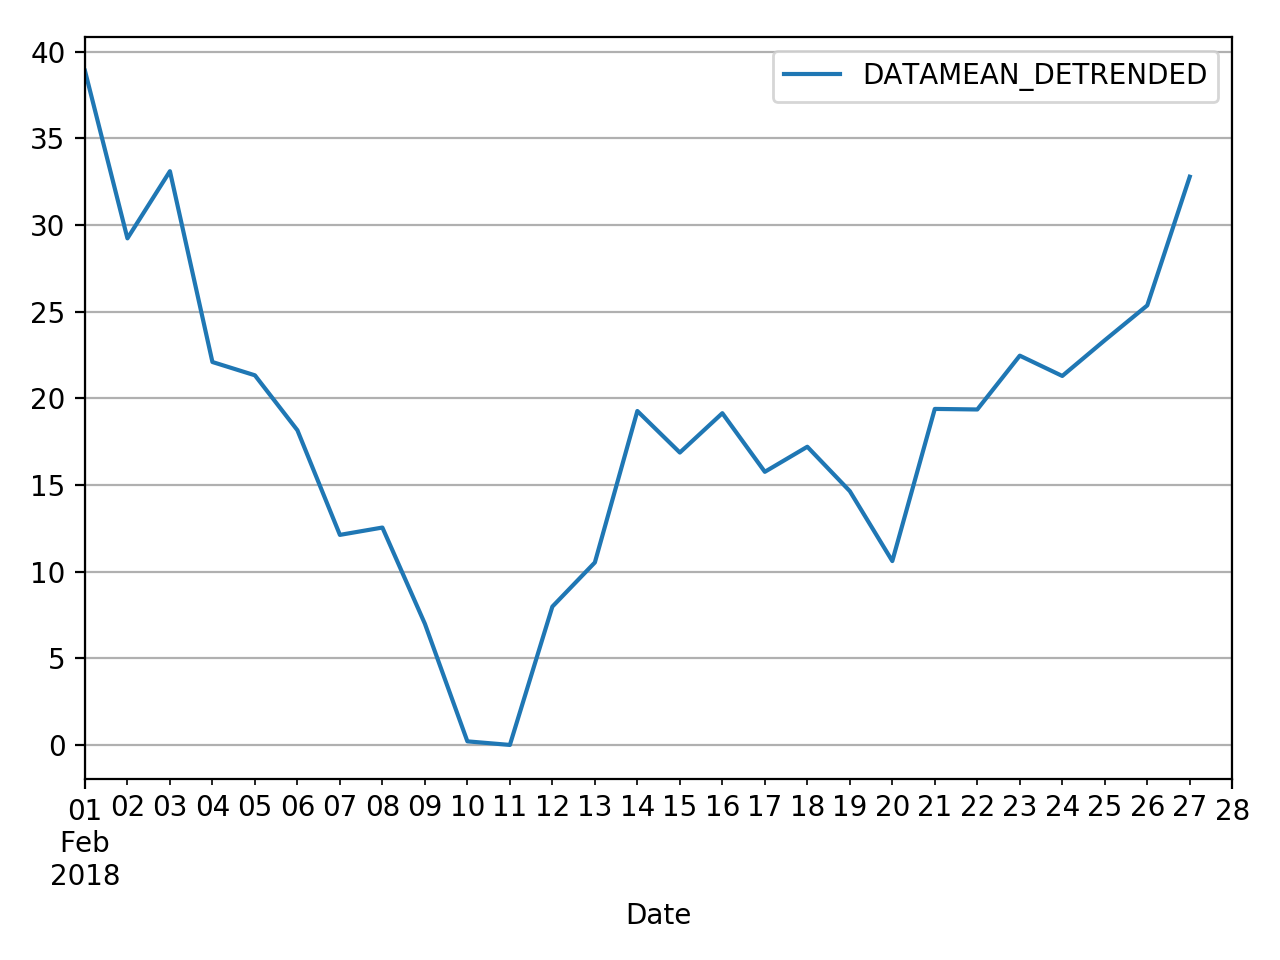

In [15]:
df_data.plot(y=['DATAMEAN_DETRENDED'], xlim=[tstart, tend],
              style='-', grid=True)

plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()

### Sep 2018

In [16]:
tstart = datetime.date(2017, 8, 25)
tend = datetime.date(2017, 9, 26)
df_data = get_meandata_hmi(tstart, tend)

Query sent to Stanford's DRMS:
hmi.Ic_45s[2017.08.25_TAI/32d@24h]


<IPython.core.display.Javascript object>


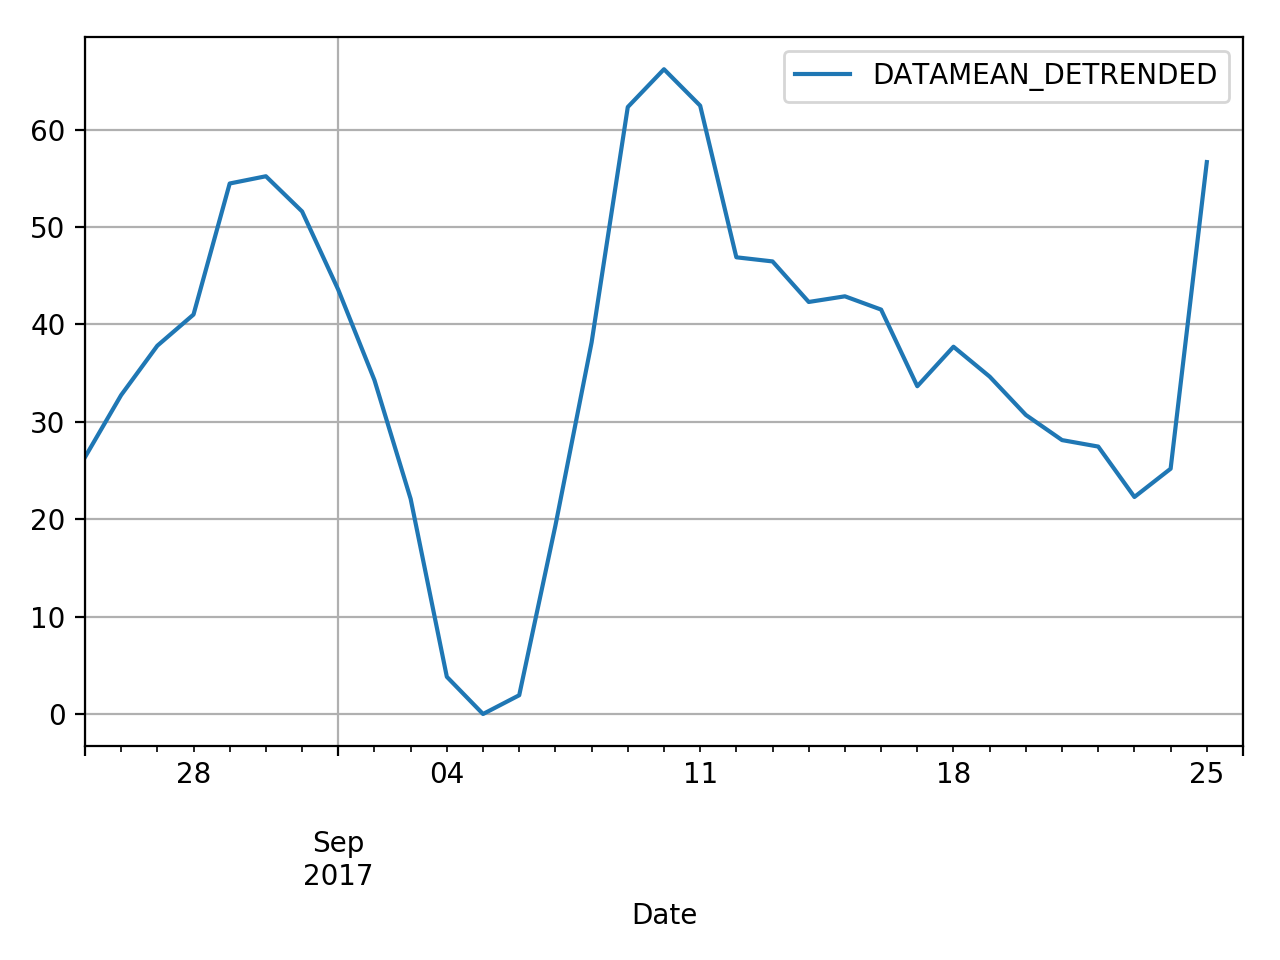

In [17]:
df_data.plot(y=['DATAMEAN_DETRENDED'], xlim=[tstart, tend], style='-', grid=True)
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()